![Spam email image](https://www.howtogeek.com/wp-content/uploads/2019/04/xemail-bomb.jpg.pagespeed.gp+jp+jw+pj+ws+js+rj+rp+rw+ri+cp+md.ic.UUnEG5yZbp.jpg)
# <center><font color = #2E5266>Error Types and Costs: Case Studies</font></center>
<center>Statistical models can help us understand and make predictions about the world. But, no model is perfect. Through two real-life case studies of applied machine learning, we will explore how type I and type II errors have consequences for decision-making in different contexts, and how trying to reduce one type can increase another.</center>

***
Before we begin, recall the definitions of the following terms:
* <font color = #6E8898>Type I Error</font> is ...
* <font color = #6E8898>Type II Error</font> is ...
* <font color = #6E8898>Precision</font> is ...
* <font color = #6E8898>Recall</font> is ...

Now we will explore what is called a <font color = #6E8898>confusion matrix</font>. Now, don't be confused by the confusion matrix. We will explore what exactly it is below.

By definition, a confusion matrix $C$ is such that a cell at position $(1,3)$ called $C_{(1,3)}$ is known to be in group 1 and predicted to be in group 3.
![](data/matrix_c.png)

## Case Study: SMS Spam Data

In this dataset, we will be studying a collection of SMS messages. Some of these messages are ham ("real" messages), and some are spam. To read more about this dataset, please take a look at the `data/readme.txt` file, or visit https://archive.ics.uci.edu/ml/datasets/sms+spam+collection.

<font color=#769ECB>// **COMMENTS**: We need to explain the dataset to them. Will update later.

In [9]:
from datascience import *
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, fixed, Layout
import numpy as np
import string
import random

<font color=#769ECB>// **COMMENTS**: We should be including a description for every code cell as they have never programmed before.
    


First, we need to split the data into a testing set and a larger training set. 

In [10]:
raw_data = Table.read_table("data/SMSSpamCollection.csv")
raw_data.show(5)

In [11]:
#split training and testing
# 10% data is testing
testing = random.sample(range(raw_data.num_rows), raw_data.num_rows//10)

# 90% data is training
training = [i for i in range(raw_data.num_rows) if i not in testing]

testing = raw_data.take[testing]
testing

Class | Text
ham   | Haven't seen my facebook, huh? Lol!
ham   | Do u ever get a song stuck in your head for no reason an ...
spam  | Do you want a new Video handset? 750 any time any networ ...
ham   | No other Valentines huh? The proof is on your fb page. U ...
ham   | Ok... But they said i've got wisdom teeth hidden inside  ...
ham   | Cab is available.they pick up and drop at door steps.
ham   | I wan but too early lei... Me outside now wun b home so  ...
spam  | Welcome! Please reply with your AGE and GENDER to begin. ...
ham   | Also that chat was awesome but don't make it regular unl ...
ham   | Gosh that , what a pain. Spose I better come then.
... (532 rows omitted)

In [12]:
training = raw_data.take[training]
training

Class | Text
ham   | Ok lar... Joking wif u oni...
spam  | Free entry in 2 a wkly comp to win FA Cup final tkts 21s ...
ham   | U dun say so early hor... U c already then say...
ham   | Nah I don't think he goes to usf, he lives around here t ...
ham   | Even my brother is not like to speak with me. They treat ...
ham   | As per your request 'Melle Melle (Oru Minnaminunginte Nu ...
spam  | WINNER!! As a valued network customer you have been sele ...
spam  | Had your mobile 11 months or more? U R entitled to Updat ...
ham   | I'm gonna be home soon and i don't want to talk about th ...
spam  | SIX chances to win CASH! From 100 to 20,000 pounds txt>  ...
... (4877 rows omitted)

If you read the some of the texts, it is pretty easy to distinguish spam vs ham. However, we are interested in getting a program to tell them apart. 

Lets try looking at some differences, like the number of capital letters in a text:

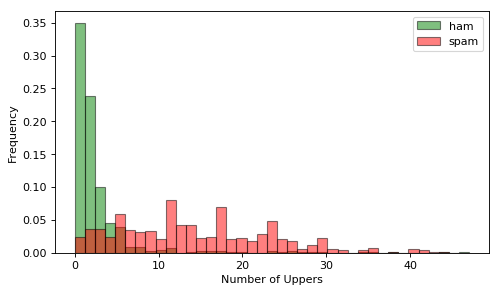

In [13]:
# function for generating a histogram! You don't need to know how it works, but feel free to see what each line does
def histogram_maker(dataset, seperation_condition, plt, title, std=None, axis=False, show_hist=True):
    # gets ham texts from dataset
    hams = dataset.where("Class", are.equal_to("ham"))
    ham_texts = hams.column("Text")
    
    # gets spam texts from dataset
    spams = dataset.where("Class", are.equal_to("spam"))
    spam_texts = spams.column("Text")
    
    # calculate/collect values (from the seperation_condition) for each ham text
    ham_vals = []
    for count in range(len(ham_texts)):
        ham_vals += [seperation_condition(ham_texts[count])]
        
    # calculate/collect values (from the seperation_condition) for each spam text
    spam_vals = []
    for count in range(len(spam_texts)):
        spam_vals += [seperation_condition(spam_texts[count])]

    # calculate bin range for histogram
    all_vals_upper = ham_vals + spam_vals
    bins = np.linspace(min(all_vals_upper), np.percentile(all_vals_upper, 99), 40)
    
    # plot histogram
    if show_hist:
        if not axis:
            plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.hist(ham_vals, alpha=.5, bins=bins, color="green", label="ham", density=True)
        plt.hist(spam_vals, alpha=.5, bins=bins, color="red", label="spam", density=True)
        if not axis:
            plt.xlabel(title)
            plt.ylabel("Frequency")
        else:
            plt.set_xlabel(title)
            plt.set_ylabel("Frequency")
        plt.legend()
    
    # calculate and return the calculated values for ham and spam DIVIDED BY the standard deviation. This is to equally 
    # weigh each statistic when making the k-nearest neighbors plot 
    if std is None:
        stdev = np.std(all_vals_upper)
    else: 
        stdev = std
    ham_vals = [i/stdev for i in ham_vals]
    spam_vals = [i/stdev for i in spam_vals]

    return (ham_vals, spam_vals, stdev)

# define a function that returns the number of Upper case letters given a text
number_of_uppers_f = (lambda text : (len([i for i in text if i.isupper()])))
# generate histogram
ham_vals_number_uppers, spam_vals_number_uppers, std_number_uppers = histogram_maker(training, number_of_uppers_f, plt, "Number of Uppers")

From the histogram above, there is a statistical difference in the number of uppercase letters between spam and ham text messsages. However, this could be because perhaps spam messages are longer in general, and so have a higher number of upper case letters as a result. Next, lets try looking at the ratio of uppercase letters within a message (ie number of uppercase letters divided by the number of characters in a text):

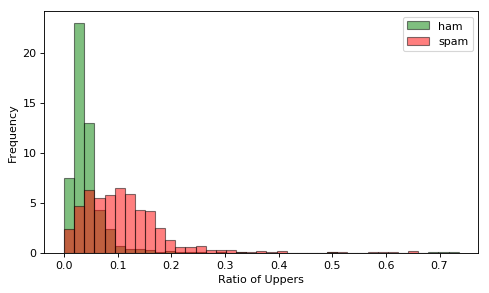

In [14]:
# define a function that returns the ratio of Upper case letters given a text
ratio_of_uppers_f = (lambda j : (len([i for i in j if i.isupper()])/len(j)))
# generate histogram
ham_vals_ratio_uppers, spam_vals_ratio_uppers, std_ratio_uppers = histogram_maker(training, ratio_of_uppers_f, plt, "Ratio of Uppers")

As you can see, it does indeed bring the spam distribution closer to the ham histogram. However, there still is a noticable shift in peaks between spam and ham messages.

This is one of many aspects that can differentiate spam vs ham messages. Discuss other features we can use to distinguish spam vs ham message in the box below.

(Double-click here)

How about we choose a specific group of characters to classify these messages; say we have certain "target characters," and we count the number of instances those characters are in the messages. We can expect a distinction between spam and ham messages, assuming we chose the right characters. We will be having you choosing some distinct characters to classify these messages. Here are some helpful guidelines in choosing these characters to make the best classifier:

    - DO NOT chose half of the characters that are common among one group, then the other half among the other. Eg, do not choose 3 characters that are associated with ham messages, then 3 characters that are associated with spam messages. These characters are to be weighted EQUALY, and so getting a number like 3 could mean a message is either spam or ham. Try to find characters that are all associated with ham messages, or characters that are associated with spam messages.
    
    - Try experiementing with the number of characters to choose, and which characters to choose!
    
    - Consider maybe looking at punctuation, numbers, or even symbols.
    
    - Need help thinking of words? Try going to the data folder and opening SMSSpamCollection.txt to read some spam/ham messages for inspiration!

In [15]:
# targets = []
# example targets list should look something like ["a", "B", "&", "7"]
targets = ["?", "!", "*"] + [i for i in string.ascii_uppercase] + [str(i) for i in range(0, 10)]
print(targets)

['?', '!', '*', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


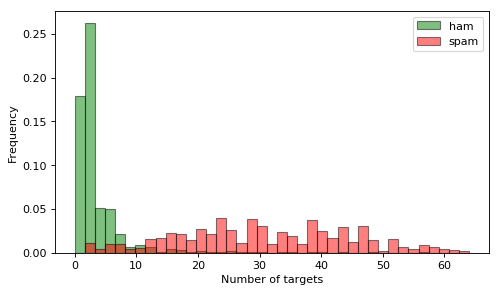

In [16]:
# define a function that returns the number of target characters given a text
num_of_targets_f = (lambda j : (len([i for i in j if i in targets])))
# generate histogram
ham_vals_num_targets, spam_vals_num_targets, std_num_targets = histogram_maker(training, num_of_targets_f, plt, "Number of targets")

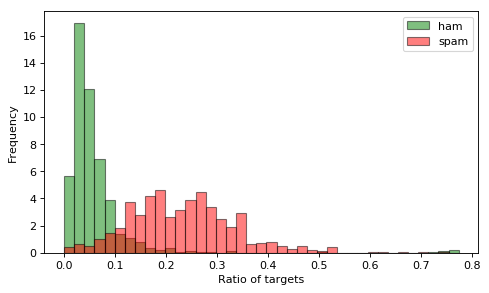

In [17]:
# define a function that returns the ratio of target characters given a text
ratio_of_targets_f = (lambda j : (len([i for i in j if i in targets])/len(j)))
# generate histogram
ham_vals_ratio_targets, spam_vals_ratio_targets, std_ratio_targets = histogram_maker(training, ratio_of_targets_f, plt, "Ratio of targets")

Now, let's look more general characteristics of the messages. For example, let's check out the distribution of the number of words and characters in a message:

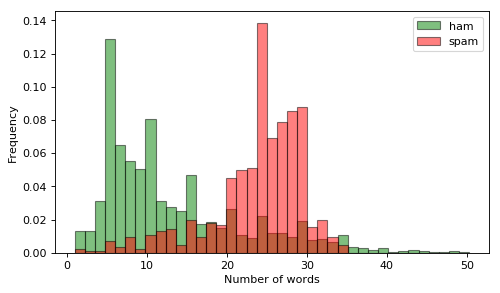

In [18]:
# define a function that returns the number of words given a text
num_words_f = (lambda j : (len([i for i in j.split(" ")])))
# generate histogram
ham_vals_num_words, spam_vals_num_words, std_num_words = histogram_maker(training, num_words_f, plt, "Number of words")

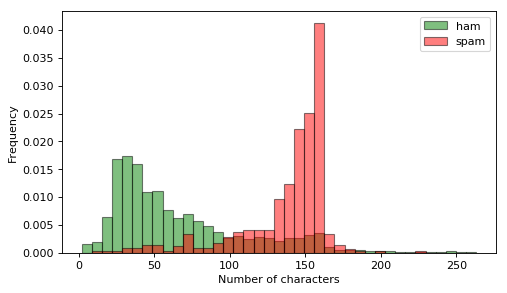

In [19]:
# define a function that returns the number of characters given a text
num_chara_f = (lambda j : (len(j)))
# generate histogram
ham_vals_num_chara, spam_vals_num_chara, std_num_chara = histogram_maker(training, num_chara_f, plt, "Number of characters")

If we combine both of these statistics, we can find the average characters per word attribute:

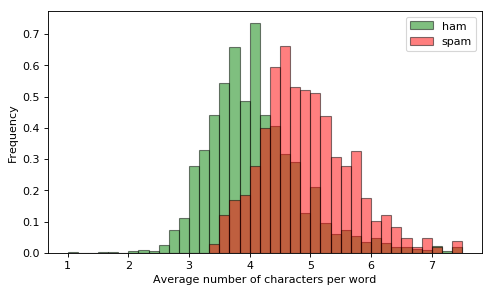

In [20]:
# define a function that returns the average number of characters per word given a text
avg_len_word_f = (lambda j : (len([i for i in j if i is not " "]))/(len([i for i in j.split(" ")])))
# generate histogram
ham_vals_avg_len_word, spam_vals_avg_len_word, std_avg_len_word = histogram_maker(training, avg_len_word_f, plt, "Average number of characters per word")

Now, if we plot one one attribute vs another, cluster the spam messages against the ham messages. Try plying around with the widget below to see which combination of attributes best differnetiate the spam messages vs the ham messages!

In [21]:
seps = [[('Number of Uppers', 0), ham_vals_number_uppers, spam_vals_number_uppers, std_number_uppers, number_of_uppers_f], 
        [('Ratio of Uppers', 1), ham_vals_ratio_uppers, spam_vals_ratio_uppers, std_ratio_uppers, ratio_of_uppers_f], 
        [('Number of Targets', 2), ham_vals_num_targets, spam_vals_num_targets, std_num_targets, num_of_targets_f],
        [('Ratio of Targets', 3), ham_vals_ratio_targets, spam_vals_ratio_targets, std_ratio_targets, ratio_of_targets_f], 
        [('Number of Words', 4), ham_vals_num_words, spam_vals_num_words, std_num_words, num_words_f], 
        [('Number of Characters', 5), ham_vals_num_chara, spam_vals_num_chara, std_num_chara, num_chara_f],
        [('Average len of words', 6), ham_vals_avg_len_word, spam_vals_avg_len_word, std_avg_len_word, avg_len_word_f],]

def plot_scatter(x, y):
    ham_x = seps[x][1]
    spam_x = seps[x][2]
    
    ham_y = seps[y][1]
    spam_y = seps[y][2]
    plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
    
    ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 2), rowspan=1)
    ax1 = plt.subplot2grid((3, 3), (2, 2), rowspan=1)
    
    histogram_maker(training, seps[x][4], ax1, seps[x][0][0], axis=True)
    histogram_maker(training, seps[y][4], ax2, seps[y][0][0], axis=True)
    
    ax3.scatter(ham_x, ham_y, color="green", alpha=0.4, label="ham message")
    ax3.scatter(spam_x, spam_y, color="red", alpha=0.4, label="spam message")

    ax3.scatter([np.mean(ham_x)], [np.mean(ham_y)], marker="*", s=400, color="green", edgecolors="black", linewidths=2, label="centroid of ham")
    ax3.scatter([np.mean(spam_x)], [np.mean(spam_y)], marker="*", s=400, color="red", edgecolors="black", linewidths=2, label="centroid of spam")
    
    ax3.set_xlabel(seps[x][0][0] + " (Normalized)")
    ax3.set_ylabel(seps[y][0][0] + " (Normalized)")
    ax3.legend()
    
    ax3.axis([np.min(ham_x+spam_x), np.percentile(ham_x+spam_x, 99.9), np.min(ham_y+spam_y), np.percentile(ham_y+spam_y, 99.9)])
    plt.tight_layout()

interact(plot_scatter, x=[i[0] for i in seps], y=[i[0] for i in seps]);

interactive(children=(Dropdown(description='x', options=(('Number of Uppers', 0), ('Ratio of Uppers', 1), ('Nu…

__EXPLAIN K NEAREST NEIGHBORS__

K-Nearest Neighbors is an algorithm that makes predictions using previous examples. In our data, we find the SMS messages in the training set that are "nearest" to an SMS we want to filter as spam or ham. The SMS is then classified based on the how the majority of nearest messages are classified. 

Each message is plotted using a pair of attributes (called features) from a training dataset and identifies each attribute as one of two categories (called labels). In the spam dataset, the labels are "spam" and "ham." 

In [22]:
attributes = [0, 1]

In [23]:
def k_nearest_neighbors(testing, seps, attribute1, attribute2, k):
    attributes = [attribute1, attribute2]
    total_x = seps[attribute1][1]+seps[attribute1][2]
    total_y = seps[attribute2][1]+seps[attribute2][2]
    ham_length=len(seps[attributes[0]][1])

    all_points = []
    for i in range(len(total_x)):
        if i < ham_length:
            all_points += [[total_x[i], total_y[i], True]]
        else:
            all_points += [[total_x[i], total_y[i], False]]
            
    texts = testing.column("Text")
    ham_vals_x, spam_vals_x = histogram_maker(testing, seps[attribute1][4], plt, " ", 
                                              show_hist=False, std=seps[attribute1][3])[0:2]
    ham_vals_y, spam_vals_y = histogram_maker(testing, seps[attributes[1]][4], plt, " ", 
                                              show_hist=False, std=seps[attribute2][3])[0:2]
    
    test_points_ham = [[ham_vals_x[i], ham_vals_y[i], True] for i in range(0, len(ham_vals_x))]
    test_points_spam = [[spam_vals_x[i], spam_vals_y[i], False] for i in range(0, len(spam_vals_x))]
    test_points = test_points_ham + test_points_spam
    
    cor_ham = 0
    cor_spam = 0
    mislabel_as_ham = 0
    mislabel_as_spam = 0
    for point in test_points:
        def distance(x, y):
           return ((x-point[0])**2 + (y-point[1])**2)**0.5
        distance_distinction = [[distance(x, y), z] for x,y,z in all_points]
        distance_distinction.sort()
        top = distance_distinction[0:k]
        hams = np.sum([i[1] for i in top])
        if (hams >= k//2+1) and (point[2]):
            cor_ham+=1
        elif (hams >= k//2+1) and not (point[2]):
            mislabel_as_ham+=1
        elif (hams < k//2+1) and not (point[2]):
            cor_spam+=1
        elif (hams < k//2+1) and (point[2]):
            mislabel_as_spam+=1

    precision = (cor_ham)/(cor_ham+mislabel_as_ham)
    recall = (cor_ham)/(cor_ham+mislabel_as_spam)
    accuracy = (cor_ham+cor_spam)/(cor_ham+cor_spam+mislabel_as_ham+mislabel_as_spam)

    print("k: {}".format(k))
    print("1st attribute: {}".format(seps[attribute1][0][0]))
    print("2nd attribute: {}".format(seps[attribute2][0][0]))
    print("precision: {}".format(precision))
    print("recall: {}".format(recall))
    print("accuracy: {}".format(accuracy))

    t = Table()
    return t.with_columns(" ", ["actual ham", "actual spam"], "predicted ham", [cor_ham, mislabel_as_ham], 
                          "predicted spam", [mislabel_as_spam, cor_spam])

k_nearest_neighbors(testing, seps, attributes[0], attributes[1], 3)

k: 3
1st attribute: Number of Uppers
2nd attribute: Ratio of Uppers
precision: 0.9591836734693877
recall: 0.9215686274509803
accuracy: 0.9003690036900369


| predicted ham | predicted spam
actual ham  | 423           | 36
actual spam | 18            | 65

In [25]:
interact(k_nearest_neighbors, testing=fixed(testing), seps=fixed(seps), attribute1=[i[0] for i in seps], 
         attribute2=[i[0] for i in seps], k=widgets.IntSlider(min=1, max=1259, step=2, value=3, 
                                                              layout=Layout(width='80%')));

interactive(children=(Dropdown(description='attribute1', options=(('Number of Uppers', 0), ('Ratio of Uppers',…